<a href="https://colab.research.google.com/github/wayne-chi/Cassava_disease_detection_using_ensemble_models/blob/main/NasNetMobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
name_output = input('enter the name of your output file ').strip()

enter the name of your output file NasNet_with_sigmoid



# Import Modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape, Activation,Flatten,BatchNormalization,Conv2D,MaxPool2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision,TruePositives,TrueNegatives, FalsePositives,FalseNegatives,Accuracy

In [ ]:
import os
import shutil
import glob
import random
import warnings
# warnings.simplefilter(action='ignore',category='FutureWarning')

In [ ]:
print('hello world')


hello world


# Add GPU

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) >=1:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  1


# Make your edits

In [ ]:
this_model_name = name_output+'.h5'

In [ ]:
model_name='NASNetMobile'

In [ ]:
image_zip = 'All_cassava_data_2.zip'   #'More_Cassava.zip'#'clean_annotated_cassava.zip'

In [ ]:
## chnage home directory
home = '/content/drive/MyDrive/project/Project2.1/Script2_pure classification' #'/content/drive/MyDrive/project/Tensorflow And Keras' #

# Pull Data and Setup

In [ ]:


image_path = model_name + '_data'
os.mkdir(image_path)

shutil.copy(os.path.join(home,'Images',image_zip),image_zip)

'All_cassava_data_2.zip'

In [ ]:
shutil.unpack_archive(image_zip,os.getcwd(),'zip')

In [ ]:
folders = os.listdir(image_zip[:-4])
folders

['brownstreak_N', 'blight_N', 'Mosaic_N', 'greenmite_N']

### Edit here or type name of folder

In [ ]:
f_folders = list(filter(lambda x:  x.endswith('N') , folders) )
f_folders = sorted(f_folders)
f_folders

['Mosaic_N', 'blight_N', 'brownstreak_N', 'greenmite_N']

## Create path and arrange

In [ ]:
os.mkdir(os.path.join(image_path,'train'))
os.mkdir(os.path.join(image_path,'test'))
os.mkdir(os.path.join(image_path,'valid'))

In [ ]:
for fold in f_folders:
  src = os.path.join(image_zip[:-4],fold)
  dest = os.path.join(image_path,'train')
  shutil.move(src,dest)

  c_test_dis = os.path.join(image_path,'test',fold)
  c_valid_dis = os.path.join(image_path,'valid',fold)
  os.mkdir(c_test_dis)
  os.mkdir(c_valid_dis)

## delete xml files
  total_files = os.listdir(os.path.join(dest,fold))
  to_del = filter(lambda x: x.endswith('xml'),total_files)
  for i in to_del:
    os.remove(os.path.join(dest,fold,i))

## pick out a few and move to valid
  valid_amount = 2 * len(os.listdir(os.path.join(dest,fold)))  //10
  test_amount = len(os.listdir(os.path.join(dest,fold))) //10

  valid_samples = random.sample(os.listdir(os.path.join(dest,fold)), valid_amount)
  for f in valid_samples:
        shutil.move(os.path.join(dest,fold,f), c_valid_dis)

## pick out a few and move to test
  test_samples = random.sample(os.listdir(os.path.join(dest,fold)), test_amount)
  for k in test_samples:
        shutil.move(os.path.join(dest,fold,k), c_test_dis)

# The Plot Functions

## Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap = plt.cm.Blues):
  """
  this function prints and plots the confusion matrix
  normalization can be applied by setting normalize=True
  """
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tickmarks=  np.arange(len(classes))
  plt.xticks(tickmarks,classes,rotation=45)
  plt.yticks(tickmarks,classes)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1) [:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('confusion matrix without normalization')

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(i,j,cm[i,j],
             horizontalalignment='center',
             color = 'white' if cm[i,j] > thresh else 'black'
             )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

# Instantiate the model

In [ ]:
Home_model = tf.keras.applications.NASNetMobile(
    input_shape=None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

24227760/24227760 [==============================] - 0s 0us/step


## Preprocess

In [ ]:
from tensorflow.keras.preprocessing import image

def prepare_image(file):
  img = image.load_img(file, target_size = (224,224))
  img_array = image.img_to_array(img)
  # print(img_array.shape)
  img_array_expanded = np.expand_dims(img_array,axis=0)
  # print(img_array_expanded.shape)
  return tf.keras.applications.nasnet.preprocess_input(img_array_expanded)

## Transfer Learning

In [ ]:
train_path = os.path.join(image_path,'train')
valid_path = os.path.join(image_path,'valid')
test_path = os.path.join(image_path,'test')

In [ ]:
from keras.utils import to_categorical

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input)\
              .flow_from_directory(directory= train_path,target_size=(224,224),batch_size=10, class_mode='categorical')

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input)\
              .flow_from_directory(directory= valid_path,target_size=(224,224),batch_size=10, class_mode='categorical')

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input)\
              .flow_from_directory(directory= test_path,target_size=(224,224),batch_size=10, shuffle = False, class_mode='categorical')


Found 3663 images belonging to 4 classes.
Found 1043 images belonging to 4 classes.
Found 520 images belonging to 4 classes.


, class_mode='binary'





In [ ]:
def data_count(batch):
  classes_dict = {v:k for k,v in batch.class_indices.items()}
  train_y = pd.DataFrame(np.concatenate([batch.next()[1] for i in range(batch.__len__())]) )
  train_y.rename(classes_dict,axis=1,inplace=True)
  return train_y.sum(axis=0).astype('int')

In [ ]:
data_count(train_batches)

Mosaic_N          120
blight_N         1120
brownstreak_N    1686
greenmite_N       737
dtype: int64

In [ ]:
data_count(valid_batches)

In [ ]:
data_count(test_batches)

Mosaic_N          16
blight_N         159
brownstreak_N    240
greenmite_N      105
dtype: int64

In [ ]:
Home_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                            

In [ ]:
len(Home_model.layers)

771

In [ ]:
x = Home_model.layers[-6].output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='sigmoid')(x)

# output = s2l.output

# s2l = Reshape((-1,))(x)
# s2l = Model(inputs= Home_model.input,outputs = s2l)
# output = Dense(units=4,activation='sigmoid')(s2l.output)  ## sigmoid softmax


In [ ]:
model = Model(inputs= Home_model.input,outputs = output)

In [ ]:
for layer in  model.layers[:-10]:
  layer.trainable=False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                             

# Train The Model

In [ ]:
model.compile(
    optimizer =Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy',Recall(), Precision(),TruePositives(),TrueNegatives(), FalsePositives(),FalseNegatives()]
)

In [ ]:
epochs=  20

In [ ]:
train_labels = to_categorical(train_batches.classes)
valid_labels = to_categorical(valid_batches.classes)
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [ ]:
History = model.fit(
    train_batches,

    validation_data = valid_batches,
    epochs = epochs,
    verbose=2,

    )

In [ ]:
History.history

{'loss': [0.48211655020713806,
  0.4195868670940399,
  0.3990645110607147,
  0.38829365372657776,
  0.3790985643863678,
  0.36935365200042725,
  0.3649369180202484,
  0.3586637079715729,
  0.3499394953250885,
  0.3461695909500122,
  0.3393261432647705,
  0.3366204798221588,
  0.3322874903678894,
  0.32836994528770447,
  0.3246978521347046,
  0.32034480571746826,
  0.3166455328464508,
  0.3139459490776062,
  0.3091012239456177,
  0.3029899597167969],
 'accuracy': [0.481299489736557,
  0.5462735295295715,
  0.5686595439910889,
  0.5773955583572388,
  0.5926836133003235,
  0.5937755703926086,
  0.6063336133956909,
  0.6169806122779846,
  0.6213486194610596,
  0.6238056421279907,
  0.634998619556427,
  0.6325416564941406,
  0.6358176469802856,
  0.6486486196517944,
  0.6453726291656494,
  0.653835654258728,
  0.6562926769256592,
  0.6587496399879456,
  0.664755642414093,
  0.6748566627502441],
 'recall': [0.4130493998527527,
  0.47502046823501587,
  0.5126945376396179,
  0.5342615246772766

In [ ]:
import pandas as pd

In [ ]:
history_df = pd.DataFrame(History.history)

In [ ]:
history_df.to_csv(os.path.join(home,'output',name_output+'.csv'))

In [ ]:
this_model_name

## Load Model

In [ ]:
model_path = os.path.join(home,'models',this_model_name)
# home = '/content/drive/MyDrive/project/Tensorflow And Keras' #/content/drive/MyDrive/project/Project2.1/Script2_pure classification

In [ ]:
loaded_model = keras.models.load_model(model_path)

In [ ]:
model = loaded_model

# Predict

In [ ]:
img = "/content/hhe.jpg"
img = prepare_image(img)
# img

In [ ]:
classes_dict = {v:k for k,v in test_batches.class_indices.items()}
classes_dict

{0: 'Mosaic_N', 1: 'blight_N', 2: 'brownstreak_N', 3: 'greenmite_N'}

In [ ]:
pred = model.predict(img)
probs = pred[0].tolist()

# Print the disease probabilities
print(probs)

1/1 [==============================] - 0s 43ms/step
[0.07918538898229599, 0.06910735368728638, 0.7331756353378296, 0.11853156983852386]


In [ ]:
test_labels= test_batches.classes

In [ ]:
x_test =  np.concatenate([test_batches.next()[0] for i in range(test_batches.__len__())])

In [ ]:
predictions = model.predict(  x = x_test,verbose=0)

In [ ]:
dff = pd.DataFrame(predictions)

In [ ]:
dff['test'] = test_labels
dff.sample(10)

,0,1,2,3,test
438,0.027879,0.040271,0.231062,0.700788,3
503,0.169871,0.029514,0.337082,0.463533,3
266,0.020649,0.657721,0.296743,0.024886,2
468,0.001565,0.212214,0.545641,0.240580,3
421,0.174168,0.209370,0.535473,0.080988,3
400,0.159741,0.045966,0.522034,0.272258,2
481,0.129285,0.003897,0.866169,0.000650,3
278,0.001597,0.350123,0.642147,0.006133,2
476,0.057270,0.847830,0.072974,0.021926,3
11,0.470694,0.008321,0.468814,0.052171,0


### Take prediction probabilities to a csv file

In [ ]:
dff.to_csv(os.path.join(home,'output',name_output+'_prediction_probabilities.csv'))

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_pred = np.argmax(predictions,axis=-1),y_true=test_labels)

In [ ]:
conf_mat = pd.DataFrame(cm)
classes_dict = {v:k for k,v in test_batches.class_indices.items()}
conf_mat.rename(classes_dict,inplace=True,axis=0)
conf_mat.rename(classes_dict,inplace=True,axis=1)
conf_mat

,Mosaic_N,blight_N,brownstreak_N,greenmite_N
Mosaic_N,10,1,2,3
blight_N,3,55,92,9
brownstreak_N,12,75,130,23
greenmite_N,7,18,61,19


### Take confusion matrix to a csv file

In [ ]:
conf_mat.to_csv(os.path.join(home,'output',name_output+'_confusion_matix.csv'))


In [ ]:
test_batches.class_indices

{'Mosaic_N': 0, 'blight_N': 1, 'brownstreak_N': 2, 'greenmite_N': 3}

In [ ]:
cm_plot_labels = [i for i in test_batches.class_indices.keys()]

confusion matrix without normalization


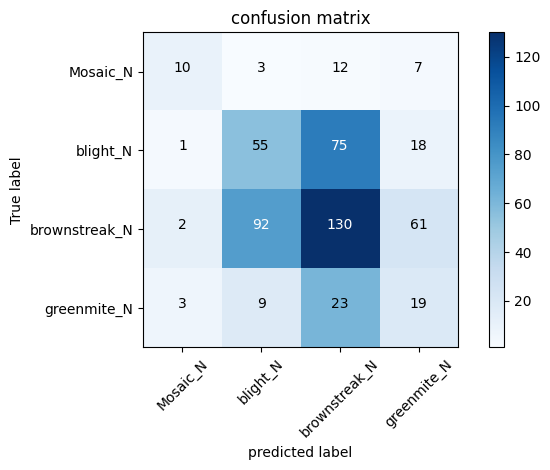

In [ ]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title = 'confusion matrix')

### piclkle the variables

In [ ]:
## piclkle the variables
import pickle

In [ ]:
pck_loc = os.path.join(home,'output','classes_dict'+'.pkl')

In [ ]:
with open(pck_loc, 'wb') as file:

    # A new file will be created
    pickle.dump(classes_dict, file)

# Save Model

In [ ]:
model.save(this_model_name)

In [ ]:
model_path = os.path.join(home,'models')
# home = '/content/drive/MyDrive/project/Tensorflow And Keras' #/content/drive/MyDrive/project/Project2.1/Script2_pure classification

In [ ]:
shutil.move(this_model_name,model_path)

'/content/drive/MyDrive/project/Project2.1/Script2_pure classification/models/NasNetMobile.h5'